In [1]:
# Importing basic libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random 
import os
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Loading the dataset CSV files
train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

In [3]:
# Displaying number of samples
print('Number of train samples: ', train.shape[0])

Number of train samples:  3662


In [4]:
print("\nTrain dataset info:")
train.info()


Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [5]:
# Checking missing values
print("Missing Values in Train:\n", train.isnull().sum())

Missing Values in Train:
 id_code      0
diagnosis    0
dtype: int64


In [6]:
#heading columns of the training dataset
train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


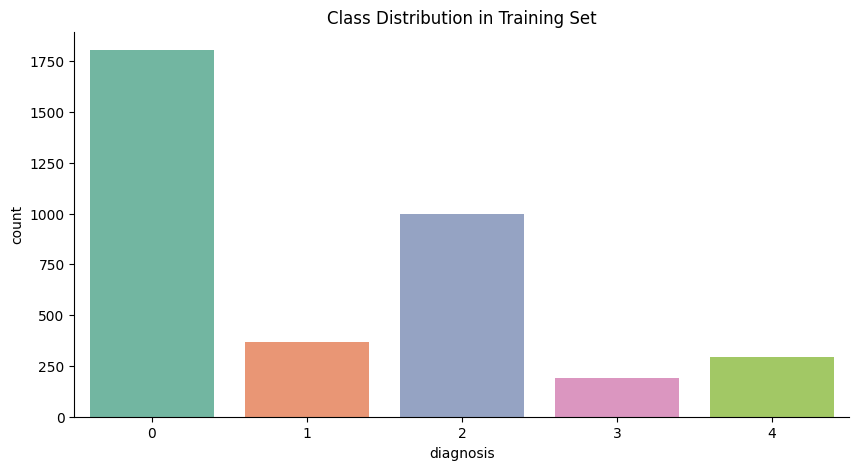

In [7]:
# class distribution in the training set
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x="diagnosis", data=train, palette="Set2", ax=ax)
sns.despine()
plt.title("Class Distribution in Training Set")
plt.show()

In [8]:
# Setting parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 3

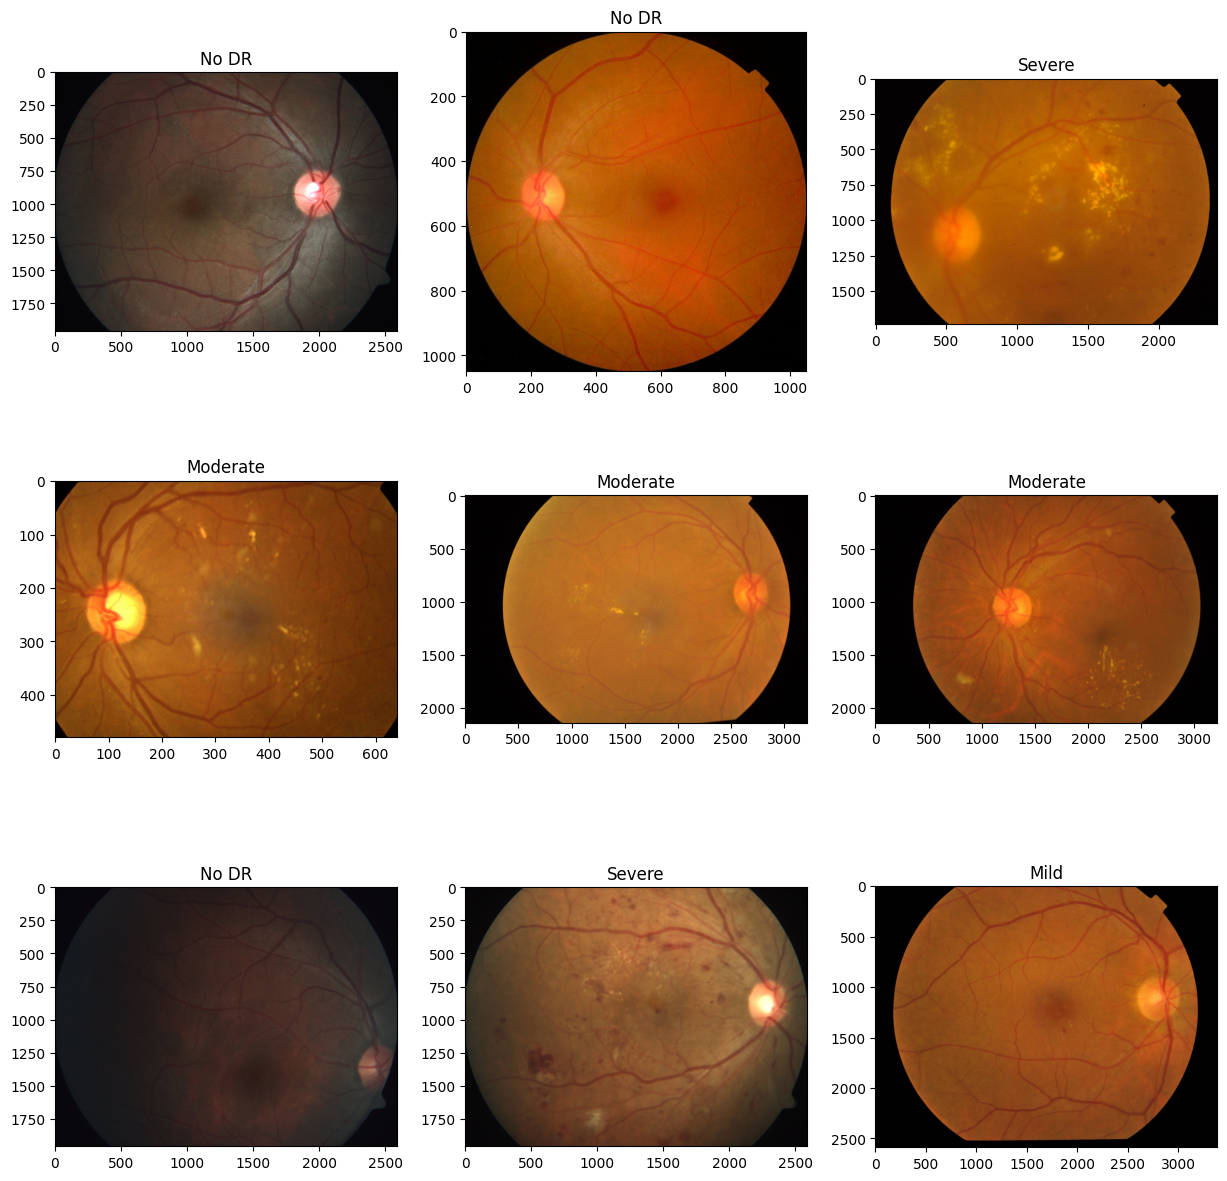

In [9]:
label_dic = {
    "0":"No DR",
    "1" : "Mild",
    "2":"Moderate",
    "3":"Severe",
    "4":"Proliferative DR"
}

# Checking Some Samples and Their Label
rows = 3
cols = 3
count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

indx = random.sample(range(train.shape[0]), rows * cols)

for i in range(rows):
    for j in range(cols):        
        if count < len(indx):
            img_path = "/kaggle/input/aptos2019-blindness-detection/train_images/"+train.iloc[indx[count],0]+".png"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i,j].set_title(label_dic[str(train.iloc[indx[count],1])])
            count+=1

In [10]:
# Combining classes into 3 categories
train['diagnosis'] = train['diagnosis'].replace({0: 0, 1: 1, 2: 1, 3: 2, 4: 2})

label_dict = {
    0: 'No Disease',
    1: 'Mild Disease',
    2: 'Severe Disease'
}

class_distribution = train['diagnosis'].value_counts().sort_index()
class_distribution.index = class_distribution.index.map(label_dict)

print("Updated class distribution:\n", class_distribution)

Updated class distribution:
 diagnosis
No Disease        1805
Mild Disease      1369
Severe Disease     488
Name: count, dtype: int64


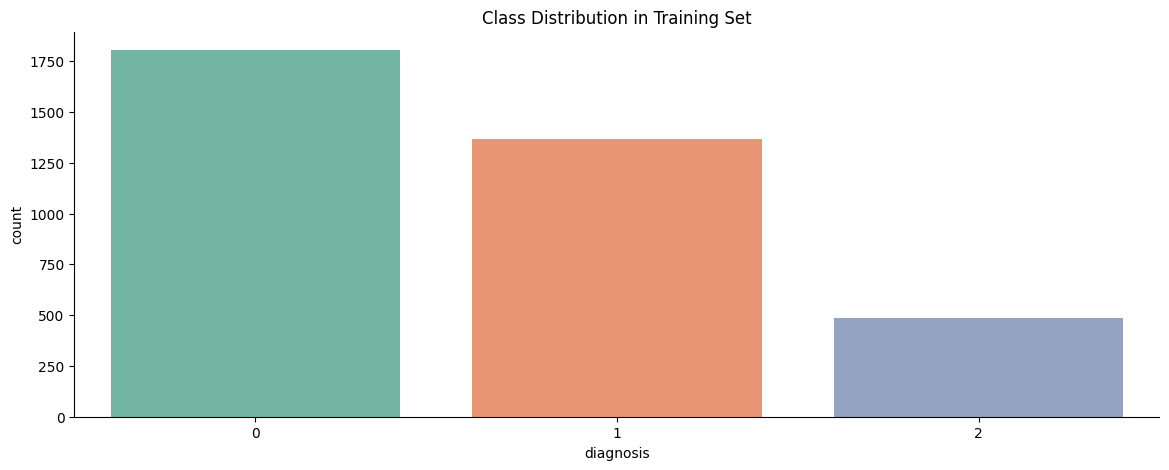

In [11]:
# Bar chart show the distribution of classes
f, ax = plt.subplots(figsize=(14, 5))
ax = sns.countplot(x="diagnosis", data=train, palette="Set2")
sns.despine()
plt.title("Class Distribution in Training Set")
plt.show()

In [12]:
# Appending '.png' to file names
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')

In [13]:
# Generating augmented training image data
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True,
                                 rotation_range=20,      
                                 zoom_range=0.15,       
                                 width_shift_range=0.2,  
                                 height_shift_range=0.2)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(224, 224),
    subset='training')

Found 2930 validated image filenames belonging to 3 classes.


In [14]:
# Generating augmented validation image data
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/kaggle/input/aptos2019-blindness-detection/train_images",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(224, 224),
    subset='validation',
    seed=42)

Found 732 validated image filenames belonging to 3 classes.


In [15]:
# Calculating class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis']),
    y=train['diagnosis']
)
class_weights_dict = dict(zip(np.unique(train['diagnosis']), class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {'0': 0.676269621421976, '1': 0.8916484051619187, '2': 2.501366120218579}


In [16]:
# Displaying class distribution in training and validation sets 
print("Training class distribution:\n", train['diagnosis'].value_counts())
print("Validation class distribution:\n", train[train['id_code'].isin(valid_generator.filenames)]['diagnosis'].value_counts())

Training class distribution:
 diagnosis
0    1805
1    1369
2     488
Name: count, dtype: int64
Validation class distribution:
 diagnosis
0    337
1    298
2     97
Name: count, dtype: int64
